In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, learning_curve, RandomizedSearchCV, TimeSeriesSplit, train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.svm import SVR, LinearSVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, IsolationForest, RandomForestRegressor, RandomTreesEmbedding, StackingRegressor

In [130]:
X_imp_cl = pd.read_csv('X_wwcode_clusters.csv', index_col='DateTime', parse_dates=['DateTime'])
y = pd.read_csv('generation_data.csv', parse_dates=['DateTime'], index_col=["DateTime"])

X_imp_cl = X_imp_cl.drop('wwcode_description', axis=1)
X_imp_cl.columns = [i.replace(' ', '_') for i in X_imp_cl.columns]

X_imp_cl_test = X_imp_cl[y.index.max() + pd.DateOffset(hours=1):]
X_imp_cl_model = X_imp_cl[:y.index.max()]
print(X_imp_cl_test.index.max())
print(y.index.max())
print(X_imp_cl_model.index.max())

2021-12-31 23:00:00
2021-11-30 23:00:00
2021-11-30 23:00:00


In [150]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


y_lag = series_to_supervised(y, 24,1)
#y_lag.columns = [y.columns[0]+'_t_1',y.columns[0]+'_t'] 
y_lag.head(10)

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,0.000000,0.000000,0.000008,0.000000,0.000008,0.000000,0.000000,1.072304,12.884461,48.924128,...,56.616417,17.433793,0.731972,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008
2019-01-02 01:00:00,0.000000,0.000008,0.000000,0.000008,0.000000,0.000000,1.072304,12.884461,48.924128,96.165907,...,17.433793,0.731972,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000
2019-01-02 02:00:00,0.000008,0.000000,0.000008,0.000000,0.000000,1.072304,12.884461,48.924128,96.165907,129.282284,...,0.731972,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000
2019-01-02 03:00:00,0.000000,0.000008,0.000000,0.000000,1.072304,12.884461,48.924128,96.165907,129.282284,147.562781,...,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000008
2019-01-02 04:00:00,0.000008,0.000000,0.000000,1.072304,12.884461,48.924128,96.165907,129.282284,147.562781,140.830250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000008,0.000000
2019-01-02 05:00:00,0.000000,0.000000,1.072304,12.884461,48.924128,96.165907,129.282284,147.562781,140.830250,111.398018,...,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000008,0.000000,0.000008
2019-01-02 06:00:00,0.000000,1.072304,12.884461,48.924128,96.165907,129.282284,147.562781,140.830250,111.398018,56.616417,...,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000008,0.000000,0.000008,0.000000
2019-01-02 07:00:00,1.072304,12.884461,48.924128,96.165907,129.282284,147.562781,140.830250,111.398018,56.616417,17.433793,...,0.000000,0.000000,0.000008,0.000000,0.000000,0.000008,0.000000,0.000008,0.000000,0.753898
2019-01-02 08:00:00,12.884461,48.924128,96.165907,129.282284,147.562781,140.830250,111.398018,56.616417,17.433793,0.731972,...,0.000000,0.000008,0.000000,0.000000,0.000008,0.000000,0.000008,0.000000,0.753898,8.417084


In [151]:
y_lag = y_lag[['var1(t)', 'var1(t-24)']]
y_lag

,var1(t),var1(t-24)
DateTime,,
2019-01-02 00:00:00,0.000008,0.000000
2019-01-02 01:00:00,0.000000,0.000000
2019-01-02 02:00:00,0.000000,0.000008
2019-01-02 03:00:00,0.000008,0.000000
2019-01-02 04:00:00,0.000000,0.000008
...,...,...
2021-11-30 19:00:00,0.000000,0.000000
2021-11-30 20:00:00,0.000000,0.000000
2021-11-30 21:00:00,0.000000,0.000000


In [152]:
print(y_lag.index.min())
print(y_lag.index.max())

2019-01-02 00:00:00
2021-11-30 23:00:00


In [153]:
X_imp_cl_model_lag = pd.DataFrame(index=X_imp_cl_model.index)

for col in X_imp_cl_model.columns:
    sts_col = series_to_supervised(X_imp_cl_model[[col]], 1, 1)
    sts_col.columns = [col+'_t_1',col+'_t'] 
    X_imp_cl_model_lag = X_imp_cl_model_lag.merge(sts_col, left_index=True, right_index=True, how='left')
X_imp_cl_model_lag = X_imp_cl_model_lag.dropna(axis=0)
X_imp_cl_model_lag.head()

,AirTemperature_t_1,AirTemperature_t,ComfortTemperature_t_1,ComfortTemperature_t,RelativeHumidity_t_1,RelativeHumidity_t,WindSpeed_t_1,WindSpeed_t,WindDirection_t_1,WindDirection_t,...,thunderstorm_slight_moderate_t_1,thunderstorm_slight_moderate_t,visibility_reduce_smoke_t_1,visibility_reduce_smoke_t,widespread_dust_suspension_t_1,widespread_dust_suspension_t,without_hail_rain_t_1,without_hail_rain_t,Day_t_1,Day_t
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,-1.7,-1.8,-6.1,-5.3,75.3,75.3,3.6,2.6,60.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2019-01-01 02:00:00,-1.8,-2.0,-5.3,-6.0,75.3,74.7,2.6,3.1,70.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2019-01-01 03:00:00,-2.0,-1.9,-6.0,-5.9,74.7,76.4,3.1,3.1,80.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2019-01-01 04:00:00,-1.9,-2.0,-5.9,-7.1,76.4,76.4,3.1,4.6,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2019-01-01 05:00:00,-2.0,-2.1,-7.1,-6.6,76.4,75.2,4.6,3.6,60.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [154]:
lag1_cols = ['AirTemperature_t_1', 'ComfortTemperature_t_1', 'RelativeHumidity_t_1', 'WindSpeed_t_1', 'WindDirection_t_1', 
'EffectiveCloudCover_t_1']
for col in X_imp_cl_model_lag.columns:
    if 't_1' in col:
        if col not in lag1_cols:
            X_imp_cl_model_lag.drop(col, axis=1, inplace=True)
            
X_imp_cl_model_lag.columns            

Index(['AirTemperature_t_1', 'AirTemperature_t', 'ComfortTemperature_t_1',
       'ComfortTemperature_t', 'RelativeHumidity_t_1', 'RelativeHumidity_t',
       'WindSpeed_t_1', 'WindSpeed_t', 'WindDirection_t_1', 'WindDirection_t',
       'WWCode_t', 'EffectiveCloudCover_t_1', 'EffectiveCloudCover_t',
       'is_holiday_t', 'Hour_t', 'DayGroup_t', 'Month_t', 'Autumn_t',
       'Spring_t', 'Summer_t', 'Winter_t', 'wwcode_cluster_t',
       'become_less_developed_t', 'cloud_development_observe_t',
       'cloud_generally_dissolve_t', 'cloud_generally_form_t',
       'development_observe_observable_t', 'dissolve_become_less_t',
       'dust_suspension_air_t', 'fall_snowflake_slight_t',
       'freeze_intermittent_slight_t', 'generally_dissolve_become_t',
       'generally_form_develop_t', 'hail_rain_snow_t',
       'moderate_without_hail_t', 'rain_freeze_intermittent_t',
       'rain_shower_slight_t', 'sky_whole_unchanged_t',
       'slight_moderate_without_t', 'state_sky_whole_t',
       

In [155]:
X_imp_cl_test_lag = pd.DataFrame(index=X_imp_cl_test.index)

for col in X_imp_cl_test.columns:
    sts_col = series_to_supervised(X_imp_cl_test[[col]], 1, 1)
    sts_col.columns = [col+'_t_1',col+'_t'] 
    X_imp_cl_test_lag = X_imp_cl_test_lag.merge(sts_col, left_index=True, right_index=True, how='left')
X_imp_cl_test_lag = X_imp_cl_test_lag.dropna(axis=0)
X_imp_cl_test_lag = X_imp_cl_test_lag[X_imp_cl_model_lag.columns]
X_imp_cl_test_lag.head()

,AirTemperature_t_1,AirTemperature_t,ComfortTemperature_t_1,ComfortTemperature_t,RelativeHumidity_t_1,RelativeHumidity_t,WindSpeed_t_1,WindSpeed_t,WindDirection_t_1,WindDirection_t,...,rain_freeze_intermittent_t,rain_shower_slight_t,sky_whole_unchanged_t,slight_moderate_without_t,state_sky_whole_t,thunderstorm_slight_moderate_t,visibility_reduce_smoke_t,widespread_dust_suspension_t,without_hail_rain_t,Day_t
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-12-01 01:00:00,4.9,4.9,4.7,4.7,86.9,86.9,1.0,0.5,210.0,210.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-01 02:00:00,4.9,4.5,4.7,4.3,86.9,84.4,0.5,1.0,210.0,210.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-01 03:00:00,4.5,3.7,4.3,3.5,84.4,86.8,1.0,1.5,210.0,200.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-01 04:00:00,3.7,3.7,3.5,3.5,86.8,86.8,1.5,1.0,200.0,210.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-01 05:00:00,3.7,2.9,3.5,2.7,86.8,90.5,1.0,1.5,210.0,220.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [159]:
X_imp_cl_model_lag2 = X_imp_cl_model_lag.merge(y_lag["var1(t-24)"], left_index=True, right_index=True, how='left').dropna()
print(X_imp_cl_model_lag.shape)
print(X_imp_cl_model_lag2.shape)

(25559, 45)
(25536, 46)


In [485]:
y_lag.shape

(25536, 2)

In [484]:
X_imp_cl_model_lag2.to_csv('X_imp_cl_model_lag2.csv')
y_lag.to_csv('y_lag.csv')
X_imp_cl_test_lag.to_csv('X_imp_cl_test_lag.csv')

In [454]:
X_train = X_imp_cl_model_lag2[X_imp_cl_model_lag2.index.isin(X_imp_cl_model_lag2[:'2021-08-31'].index)]
X_train = X_train.rename(columns={'var1(t-24)': 'generation_t_24'})

y1 = y[y.index.isin(X_imp_cl_model_lag2[:'2021-08-31'].index)]
y_train = y1[y1.index.isin(X_train.index)]

X_val = X_imp_cl_model_lag2[~X_imp_cl_model_lag2.index.isin(X_train.index)]
X_val = X_val.rename(columns={'var1(t-24)': 'generation_t_24'})

y_val = y[y.index.isin(X_val.index)]

print('total data shape:',X_imp_cl_model_lag2.shape)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

total data shape: (25536, 46)
X_train shape: (23352, 46)
y_train shape: (23352, 1)
X_val shape: (2184, 46)
y_val shape: (2184, 1)


In [445]:
X_train.to_csv('X_imp_cl_train_lag.csv')
X_val.to_csv('X_imp_cl_val_lag.csv')
y_train.to_csv('y_imp_cl_train_lag.csv')
y_val.to_csv('y_imp_cl_val_lag.csv')

In [38]:
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor

In [449]:
def build_model(_alpha, _l1_ratio):
    estimator = ElasticNet(
        alpha=_alpha,
        l1_ratio=_l1_ratio,
        fit_intercept=True,
        normalize=False,
        precompute=False,
        max_iter=16,
        copy_X=True,
        tol=0.1,
        warm_start=False,
        positive=False,
        random_state=None,
        selection='random'
    )

    return MultiOutputRegressor(estimator, n_jobs=4)

In [455]:
model = LGBMRegressor(random_state=42, n_jobs=-1, n_estimators=100)

mse = make_scorer(mean_squared_error,greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=mse)
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
print([np.sqrt(i*-1) for i in scores])

Loss: -746.161 (+/- 126.865)
[25.602233547137484, 31.02746306766409, 24.982425247741443, 25.921859459090037, 28.575594554698654]


In [456]:
model = LGBMRegressor(random_state=42, n_jobs=-1, n_estimators=1000)
kfcv = KFold(n_splits=5)
scores = cross_val_score(model, X_train, y_train, cv=kfcv, scoring=mse)
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
print([np.sqrt(i*-1) for i in scores])

Loss: -728.712 (+/- 135.324)
[30.30741694856101, 25.705593488272545, 26.45690510663483, 23.041156615615822, 28.86834374890203]


In [457]:
X_train.columns

Index(['AirTemperature_t_1', 'AirTemperature_t', 'ComfortTemperature_t_1',
       'ComfortTemperature_t', 'RelativeHumidity_t_1', 'RelativeHumidity_t',
       'WindSpeed_t_1', 'WindSpeed_t', 'WindDirection_t_1', 'WindDirection_t',
       'WWCode_t', 'EffectiveCloudCover_t_1', 'EffectiveCloudCover_t',
       'is_holiday_t', 'Hour_t', 'DayGroup_t', 'Month_t', 'Autumn_t',
       'Spring_t', 'Summer_t', 'Winter_t', 'wwcode_cluster_t',
       'become_less_developed_t', 'cloud_development_observe_t',
       'cloud_generally_dissolve_t', 'cloud_generally_form_t',
       'development_observe_observable_t', 'dissolve_become_less_t',
       'dust_suspension_air_t', 'fall_snowflake_slight_t',
       'freeze_intermittent_slight_t', 'generally_dissolve_become_t',
       'generally_form_develop_t', 'hail_rain_snow_t',
       'moderate_without_hail_t', 'rain_freeze_intermittent_t',
       'rain_shower_slight_t', 'sky_whole_unchanged_t',
       'slight_moderate_without_t', 'state_sky_whole_t',
       

In [458]:
model_list = [LGBMRegressor(n_jobs=-1, random_state=42), RandomForestRegressor(n_jobs=-1, random_state=42), 
              XGBRegressor(n_jobs=-1, random_state=42, objective='reg:squarederror'),ExtraTreesRegressor(random_state=42), 
              GradientBoostingRegressor(random_state=42), BaggingRegressor(random_state=42), LinearSVR(random_state=42)
             ]

train_rmses = []
train_maes = []
train_r2s = []
val_rmses = []
val_maes = []
val_r2s = []
times = []
counter = 0

print("Prediction started...")
for model in model_list:
    mod = model
    start_time = time.time()
    mod.fit(X_train, np.ravel(y_train))
    end_time = time.time()
    train_pred = mod.predict(X_train)
    val_pred = mod.predict(X_val)
    
    train_rmses.append(mean_squared_error(np.ravel(y_train), train_pred, squared=False))
    train_maes.append(mean_absolute_error(np.ravel(y_train), train_pred))
    train_r2s.append(r2_score(np.ravel(y_train), train_pred))
    
    val_rmses.append(mean_squared_error(np.ravel(y_val), val_pred, squared=False))
    val_maes.append(mean_absolute_error(np.ravel(y_val), val_pred))
    val_r2s.append(r2_score(np.ravel(y_val), val_pred))

    times.append(end_time - start_time)
    print("Model",counter,"is completed")
    counter += 1
print("Prediction is completed...")    

Prediction started...
Model 0 is completed
Model 1 is completed
Model 2 is completed
Model 3 is completed
Model 4 is completed
Model 5 is completed
Model 6 is completed
Prediction is completed...


c:\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [459]:
modelsdf = pd.DataFrame(
    {
     'model': model_list,
     'train_rmse': train_rmses,
     'train_mae': train_maes,
     'train_r2': train_r2s,
     'val_rmse': val_rmses,
     'val_mae': val_maes,
     'val_r2': val_r2s,   
     'duration': times
    })

modelsdf.sort_values(by='val_rmse', ascending=True)

,model,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2,duration
0,LGBMRegressor(random_state=42),1.691996e+01,8.679511e+00,0.981865,25.499875,12.411016,0.962770,0.413000
4,([DecisionTreeRegressor(criterion='friedman_ms...,2.364537e+01,1.219790e+01,0.964582,26.220517,13.414814,0.960636,5.780972
2,"XGBRegressor(n_jobs=-1, objective='reg:squared...",2.370446e+01,1.226705e+01,0.964405,26.408466,13.599756,0.960069,2.304884
3,"(ExtraTreeRegressor(random_state=1608637542), ...",2.096707e-13,1.060318e-13,1.000000,26.502116,13.042108,0.959786,18.124028
1,"(DecisionTreeRegressor(max_features='auto', ra...",8.462941e+00,4.105462e+00,0.995463,26.821807,13.376087,0.958810,6.235635
5,(DecisionTreeRegressor(random_state=1952926171...,1.029991e+01,4.723011e+00,0.993280,28.041360,14.012249,0.954979,2.907004
6,LinearSVR(random_state=42),5.224522e+01,3.539687e+01,0.827090,52.075532,35.263960,0.844730,3.537975


**LSTM**

In [399]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, RNN, Conv2D, Flatten, Activation, Concatenate
from keras.metrics import RootMeanSquaredError
from numpy import concatenate
from keras.callbacks import ModelCheckpoint

In [460]:
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#divide the data into train and test data

#index the data into dependent and independent variables
print(X_train_scaled.shape, y_train.shape, X_val_scaled.shape, y_val.shape)

#convert data into suitable dimension for using it as input in LSTM network
train_X = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
val_X = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
print(train_X.shape, y_train.shape, val_X.shape, y_val.shape)

(23352, 46) (23352, 1) (2184, 46) (2184, 1)
(23352, 1, 46) (23352, 1) (2184, 1, 46) (2184, 1)


In [442]:
model = Sequential()
model.add(LSTM(46, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 1, 46)             17112     
_________________________________________________________________
dense_93 (Dense)             (None, 1, 32)             1504      
_________________________________________________________________
dropout_59 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dropout_60 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_94 (Dense)             (None, 1, 1)              33        
Total params: 26,969
Trainable params: 26,969
Non-trainable params: 0
_________________________________________________

In [443]:
mc=ModelCheckpoint('best_model.h5', monitor='val_mse', mode='min', save_best_only=True,verbose=1)  

history = model.fit(train_X, y_train, epochs=100, batch_size=64, validation_data=(val_X, y_val), verbose=1, shuffle=False, callbacks=[mc])


Epoch 1/100
365/365 [==============================] - 5s 7ms/step - loss: 22147.3457 - root_mean_squared_error: 148.8198 - val_loss: 23131.6270 - val_root_mean_squared_error: 152.0909
Epoch 2/100
365/365 [==============================] - 2s 5ms/step - loss: 20346.9805 - root_mean_squared_error: 142.6428 - val_loss: 21644.2734 - val_root_mean_squared_error: 147.1199
Epoch 3/100
365/365 [==============================] - 2s 5ms/step - loss: 18980.5605 - root_mean_squared_error: 137.7700 - val_loss: 20283.9844 - val_root_mean_squared_error: 142.4219
Epoch 4/100
365/365 [==============================] - 2s 5ms/step - loss: 17767.9160 - root_mean_squared_error: 133.2963 - val_loss: 19060.9492 - val_root_mean_squared_error: 138.0614
Epoch 5/100
365/365 [==============================] - 2s 5ms/step - loss: 16649.2969 - root_mean_squared_error: 129.0322 - val_loss: 17925.6055 - val_root_mean_squared_error: 133.8865
Epoch 6/100
365/365 [==============================] - 2s 5ms/step - loss: 

Epoch 64/100
365/365 [==============================] - 2s 5ms/step - loss: 641.9799 - root_mean_squared_error: 25.3373 - val_loss: 922.9762 - val_root_mean_squared_error: 30.3805
Epoch 65/100
365/365 [==============================] - 2s 5ms/step - loss: 636.2383 - root_mean_squared_error: 25.2238 - val_loss: 884.2054 - val_root_mean_squared_error: 29.7356
Epoch 66/100
365/365 [==============================] - 2s 5ms/step - loss: 618.2541 - root_mean_squared_error: 24.8647 - val_loss: 852.2227 - val_root_mean_squared_error: 29.1929
Epoch 67/100
365/365 [==============================] - 2s 5ms/step - loss: 611.0264 - root_mean_squared_error: 24.7189 - val_loss: 941.7964 - val_root_mean_squared_error: 30.6887
Epoch 68/100
365/365 [==============================] - 2s 5ms/step - loss: 606.9502 - root_mean_squared_error: 24.6364 - val_loss: 904.2806 - val_root_mean_squared_error: 30.0713
Epoch 69/100
365/365 [==============================] - 2s 5ms/step - loss: 612.2775 - root_mean_squ

Epoch 96/100
365/365 [==============================] - 2s 5ms/step - loss: 491.3788 - root_mean_squared_error: 22.1671 - val_loss: 851.1273 - val_root_mean_squared_error: 29.1741
Epoch 97/100
365/365 [==============================] - 2s 5ms/step - loss: 496.4962 - root_mean_squared_error: 22.2822 - val_loss: 819.3210 - val_root_mean_squared_error: 28.6238
Epoch 98/100
365/365 [==============================] - 2s 5ms/step - loss: 489.3187 - root_mean_squared_error: 22.1205 - val_loss: 887.9052 - val_root_mean_squared_error: 29.7977
Epoch 99/100
365/365 [==============================] - 2s 5ms/step - loss: 495.1069 - root_mean_squared_error: 22.2510 - val_loss: 771.7385 - val_root_mean_squared_error: 27.7802
Epoch 100/100
365/365 [==============================] - 2s 5ms/step - loss: 483.9224 - root_mean_squared_error: 21.9982 - val_loss: 841.8461 - val_root_mean_squared_error: 29.0146


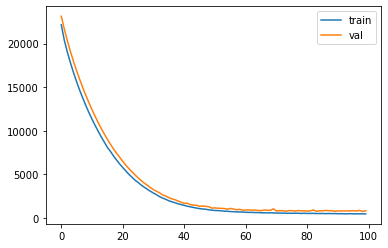

In [444]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [326]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)    

In [329]:
#prediction on training and testing data
train_predict = model.predict(train_X)    
val_predict = model.predict(val_X)  

total_capacity = 523.005001
train_predict_adj1 = [total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in train_predict]
val_predict_adj1 = [total_capacity*0.98 if i > total_capacity else 0 if i < 0 else i for i in val_predict]

train_predict_adj2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_train.index.hour, train_predict_adj1)]
val_predict_adj2 = [pred if  6 <= hour <= 19 else 0 for hour, pred in zip(y_val.index.hour, val_predict_adj1)]


print("Adj1 Train Set RMSE:", mean_squared_error(y_train, train_predict_adj1, squared=False))
print("Adj1 Train Set MAE:", mean_absolute_error(y_train, train_predict_adj1))
print("Adj1 Train Set R2:", r2_score(y_train, train_predict_adj1))

print()
print("Adj1 Val Set RMSE:", mean_squared_error(y_val, val_predict_adj1, squared=False))
print("Adj1 Val Set MAE:", mean_absolute_error(y_val, val_predict_adj1))
print("Adj1 Val Set R2:", r2_score(y_val, val_predict_adj1))
print("="*40)
print("Adj2 Train Set RMSE:", mean_squared_error(y_train, train_predict_adj2, squared=False))
print("Adj2 Train Set MAE:", mean_absolute_error(y_train, train_predict_adj2))
print("Adj2 Train Set R2:", r2_score(y_train, train_predict_adj2))

print()
print("Adj2 Val Set RMSE:", mean_squared_error(y_val, val_predict_adj2, squared=False))
print("Adj2 Val Set MAE:", mean_absolute_error(y_val, val_predict_adj2))
print("Adj2 Val Set R2:", r2_score(y_val, val_predict_adj2))

Adj1 Train Set RMSE: 24.182628921916553
Adj1 Train Set MAE: 12.558365803202866
Adj1 Train Set R2: 0.9629547123983461

Adj1 Val Set RMSE: 26.55551803870703
Adj1 Val Set MAE: 13.063994251524768
Adj1 Val Set R2: 0.9596234695210616
Adj2 Train Set RMSE: 24.172544574742126
Adj2 Train Set MAE: 12.35983347221293
Adj2 Train Set R2: 0.962985602311115

Adj2 Val Set RMSE: 26.547173047135644
Adj2 Val Set MAE: 12.935522119704073
Adj2 Val Set R2: 0.9596488419400492


In [435]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam # - Works
from keras import regularizers
import keras.backend as K

In [471]:
## Hyperparameter for Deep Learning
lr = 0.001
training_epochs = 200
display_step = 200
factor = 0.10
batch = 64
seed = 7
beta_1 = 0.5
beta_2 = 0.7
epsilon = None
decay = 0.001
np.random.seed(seed)

In [433]:
model2 = Sequential()
model2.add(Dense(128,
                input_shape=(train_X.shape[1], train_X.shape[2]),
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1))
model2.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 1, 128)            6016      
_________________________________________________________________
dropout_56 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
dense_90 (Dense)             (None, 1, 64)             8256      
_________________________________________________________________
dropout_57 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
dense_91 (Dense)             (None, 1, 32)             2080      
_________________________________________________________________
dropout_58 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_92 (Dense)             (None, 1, 1)            

In [440]:
model2.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr), metrics=[RootMeanSquaredError()])
history2 = model2.fit(train_X, y_train,
                    batch_size=batch,
                    epochs=training_epochs,
                    validation_data=(val_X, y_val)) 

Epoch 1/200
183/183 [==============================] - 1s 5ms/step - loss: 1957.1788 - root_mean_squared_error: 44.1749 - val_loss: 1349.7694 - val_root_mean_squared_error: 36.6599
Epoch 2/200
183/183 [==============================] - 1s 3ms/step - loss: 1869.7681 - root_mean_squared_error: 43.1715 - val_loss: 1082.6796 - val_root_mean_squared_error: 32.8104
Epoch 3/200
183/183 [==============================] - 1s 3ms/step - loss: 1927.0854 - root_mean_squared_error: 43.8266 - val_loss: 1200.6798 - val_root_mean_squared_error: 34.5576
Epoch 4/200
183/183 [==============================] - 1s 3ms/step - loss: 1800.4750 - root_mean_squared_error: 42.3547 - val_loss: 1058.9457 - val_root_mean_squared_error: 32.4390
Epoch 5/200
183/183 [==============================] - 1s 3ms/step - loss: 1841.4644 - root_mean_squared_error: 42.8328 - val_loss: 983.0439 - val_root_mean_squared_error: 31.2429
Epoch 6/200
183/183 [==============================] - 1s 3ms/step - loss: 1880.2251 - root_mean

183/183 [==============================] - 1s 3ms/step - loss: 1401.0280 - root_mean_squared_error: 37.1759 - val_loss: 1237.9308 - val_root_mean_squared_error: 34.9125
Epoch 92/200
183/183 [==============================] - 1s 3ms/step - loss: 1408.2788 - root_mean_squared_error: 37.2716 - val_loss: 1088.1127 - val_root_mean_squared_error: 32.6944
Epoch 93/200
183/183 [==============================] - 1s 3ms/step - loss: 1395.7886 - root_mean_squared_error: 37.1020 - val_loss: 1348.4731 - val_root_mean_squared_error: 36.4586
Epoch 94/200
183/183 [==============================] - 1s 3ms/step - loss: 1368.3483 - root_mean_squared_error: 36.7298 - val_loss: 1103.0884 - val_root_mean_squared_error: 32.9217
Epoch 95/200
183/183 [==============================] - 1s 3ms/step - loss: 1408.0908 - root_mean_squared_error: 37.2652 - val_loss: 901.3065 - val_root_mean_squared_error: 29.6949
Epoch 96/200
183/183 [==============================] - 1s 3ms/step - loss: 1378.9052 - root_mean_square

Epoch 136/200
183/183 [==============================] - 1s 3ms/step - loss: 1330.6147 - root_mean_squared_error: 36.1605 - val_loss: 1061.4364 - val_root_mean_squared_error: 32.2236
Epoch 137/200
183/183 [==============================] - 1s 3ms/step - loss: 1321.9949 - root_mean_squared_error: 36.0400 - val_loss: 952.9870 - val_root_mean_squared_error: 30.4928
Epoch 138/200
183/183 [==============================] - 1s 3ms/step - loss: 1306.9144 - root_mean_squared_error: 35.8294 - val_loss: 1139.7177 - val_root_mean_squared_error: 33.4145
Epoch 139/200
183/183 [==============================] - 1s 3ms/step - loss: 1355.8042 - root_mean_squared_error: 36.5046 - val_loss: 1253.7582 - val_root_mean_squared_error: 35.0777
Epoch 140/200
183/183 [==============================] - 1s 4ms/step - loss: 1358.0317 - root_mean_squared_error: 36.5334 - val_loss: 1007.2114 - val_root_mean_squared_error: 31.3673
Epoch 141/200
183/183 [==============================] - 1s 4ms/step - loss: 1322.1277

Epoch 181/200
183/183 [==============================] - 1s 3ms/step - loss: 1279.7218 - root_mean_squared_error: 35.3961 - val_loss: 981.5848 - val_root_mean_squared_error: 30.8988
Epoch 182/200
183/183 [==============================] - 1s 4ms/step - loss: 1297.0375 - root_mean_squared_error: 35.6391 - val_loss: 1166.0212 - val_root_mean_squared_error: 33.7503
Epoch 183/200
183/183 [==============================] - 1s 4ms/step - loss: 1282.0303 - root_mean_squared_error: 35.4259 - val_loss: 1075.9221 - val_root_mean_squared_error: 32.3859
Epoch 184/200
183/183 [==============================] - 1s 4ms/step - loss: 1287.5363 - root_mean_squared_error: 35.5024 - val_loss: 1123.9000 - val_root_mean_squared_error: 33.1166
Epoch 185/200
183/183 [==============================] - 1s 4ms/step - loss: 1268.7672 - root_mean_squared_error: 35.2351 - val_loss: 1068.5922 - val_root_mean_squared_error: 32.2690
Epoch 186/200
183/183 [==============================] - 1s 4ms/step - loss: 1279.8190

In [470]:
#TS v2

In [462]:
X_tr_t = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_t = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])

In [472]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(46, input_shape=(1, 46),
                    activation='relu',kernel_initializer='lecun_uniform',
                    return_sequences=False,
                    kernel_regularizer=regularizers.l2(0.01)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr), metrics=[RootMeanSquaredError()])
history_model_lstm = model_lstm.fit(X_tr_t,y_train,epochs=training_epochs,
                                    batch_size=batch,verbose=1,shuffle=True,
                                    validation_data=(X_val_t, y_val))

Epoch 1/200
365/365 [==============================] - 2s 3ms/step - loss: 6198.3110 - root_mean_squared_error: 78.7222 - val_loss: 1583.3582 - val_root_mean_squared_error: 39.7790
Epoch 2/200
365/365 [==============================] - 1s 3ms/step - loss: 1534.9631 - root_mean_squared_error: 39.1655 - val_loss: 1424.1729 - val_root_mean_squared_error: 37.7238
Epoch 3/200
365/365 [==============================] - 1s 2ms/step - loss: 1382.1674 - root_mean_squared_error: 37.1619 - val_loss: 1320.6844 - val_root_mean_squared_error: 36.3242
Epoch 4/200
365/365 [==============================] - 1s 2ms/step - loss: 1280.6812 - root_mean_squared_error: 35.7683 - val_loss: 1244.9944 - val_root_mean_squared_error: 35.2647
Epoch 5/200
365/365 [==============================] - 1s 2ms/step - loss: 1206.5203 - root_mean_squared_error: 34.7139 - val_loss: 1205.1458 - val_root_mean_squared_error: 34.6930
Epoch 6/200
365/365 [==============================] - 1s 2ms/step - loss: 1153.4417 - root_mea

365/365 [==============================] - 1s 2ms/step - loss: 670.5246 - root_mean_squared_error: 25.6909 - val_loss: 949.4683 - val_root_mean_squared_error: 30.6420
Epoch 92/200
365/365 [==============================] - 1s 2ms/step - loss: 670.5287 - root_mean_squared_error: 25.6896 - val_loss: 976.3365 - val_root_mean_squared_error: 31.0764
Epoch 93/200
365/365 [==============================] - 1s 2ms/step - loss: 670.4902 - root_mean_squared_error: 25.6881 - val_loss: 971.8646 - val_root_mean_squared_error: 31.0034
Epoch 94/200
365/365 [==============================] - 1s 2ms/step - loss: 661.6653 - root_mean_squared_error: 25.5144 - val_loss: 971.0320 - val_root_mean_squared_error: 30.9890
Epoch 95/200
365/365 [==============================] - 1s 2ms/step - loss: 684.3966 - root_mean_squared_error: 25.9545 - val_loss: 962.2037 - val_root_mean_squared_error: 30.8450
Epoch 96/200
365/365 [==============================] - 1s 2ms/step - loss: 666.8517 - root_mean_squared_error: 2

Epoch 181/200
365/365 [==============================] - 1s 2ms/step - loss: 569.1934 - root_mean_squared_error: 23.5431 - val_loss: 884.0519 - val_root_mean_squared_error: 29.4807
Epoch 182/200
365/365 [==============================] - 1s 2ms/step - loss: 569.7218 - root_mean_squared_error: 23.5534 - val_loss: 860.1861 - val_root_mean_squared_error: 29.0726
Epoch 183/200
365/365 [==============================] - 1s 2ms/step - loss: 573.4161 - root_mean_squared_error: 23.6310 - val_loss: 1086.0686 - val_root_mean_squared_error: 32.7270
Epoch 184/200
365/365 [==============================] - 1s 2ms/step - loss: 562.9955 - root_mean_squared_error: 23.4088 - val_loss: 854.9243 - val_root_mean_squared_error: 28.9807
Epoch 185/200
365/365 [==============================] - 1s 2ms/step - loss: 564.9846 - root_mean_squared_error: 23.4504 - val_loss: 931.3872 - val_root_mean_squared_error: 30.2706
Epoch 186/200
365/365 [==============================] - 1s 2ms/step - loss: 568.1913 - root_m

In [ ]:
#TS v3

In [473]:
X_train_filtered = X_train

X_train_filtered = X_train.drop(['Autumn_t',
       'Spring_t', 'Summer_t', 'Winter_t',
       'become_less_developed_t', 'cloud_development_observe_t',
       'cloud_generally_dissolve_t', 'cloud_generally_form_t',
       'development_observe_observable_t', 'dissolve_become_less_t',
       'dust_suspension_air_t', 'fall_snowflake_slight_t',
       'freeze_intermittent_slight_t', 'generally_dissolve_become_t',
       'generally_form_develop_t', 'hail_rain_snow_t',
       'moderate_without_hail_t', 'rain_freeze_intermittent_t',
       'rain_shower_slight_t', 'sky_whole_unchanged_t',
       'slight_moderate_without_t', 'state_sky_whole_t',
       'thunderstorm_slight_moderate_t', 'visibility_reduce_smoke_t',
       'widespread_dust_suspension_t', 'without_hail_rain_t'], axis=1)

X_val_filtered = X_val.drop(['Autumn_t',
       'Spring_t', 'Summer_t', 'Winter_t',
       'become_less_developed_t', 'cloud_development_observe_t',
       'cloud_generally_dissolve_t', 'cloud_generally_form_t',
       'development_observe_observable_t', 'dissolve_become_less_t',
       'dust_suspension_air_t', 'fall_snowflake_slight_t',
       'freeze_intermittent_slight_t', 'generally_dissolve_become_t',
       'generally_form_develop_t', 'hail_rain_snow_t',
       'moderate_without_hail_t', 'rain_freeze_intermittent_t',
       'rain_shower_slight_t', 'sky_whole_unchanged_t',
       'slight_moderate_without_t', 'state_sky_whole_t',
       'thunderstorm_slight_moderate_t', 'visibility_reduce_smoke_t',
       'widespread_dust_suspension_t', 'without_hail_rain_t'], axis=1)

In [475]:
X_tr_filt_t = X_train_filtered.values.reshape(X_train_filtered.shape[0], 1, X_train_filtered.shape[1])
X_val_filt_t = X_val_filtered.values.reshape(X_val_filtered.shape[0], 1, X_val_filtered.shape[1])

In [476]:
X_tr_filt_t.shape

(23352, 1, 20)

In [478]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(1, 20),
                    activation='relu',kernel_initializer='lecun_uniform',
                    return_sequences=False,
                    kernel_regularizer=regularizers.l2(0.01)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr), metrics=[RootMeanSquaredError()])
history_model_lstm = model_lstm.fit(X_tr_filt_t,y_train,epochs=training_epochs,
                                    batch_size=batch,verbose=1,shuffle=True,
                                    validation_data=(X_val_filt_t, y_val))

Epoch 1/200
365/365 [==============================] - 2s 4ms/step - loss: 4189.7920 - root_mean_squared_error: 64.7032 - val_loss: 1565.5797 - val_root_mean_squared_error: 39.5342
Epoch 2/200
365/365 [==============================] - 2s 4ms/step - loss: 1570.9609 - root_mean_squared_error: 39.6030 - val_loss: 1479.6150 - val_root_mean_squared_error: 38.4324
Epoch 3/200
365/365 [==============================] - 2s 4ms/step - loss: 1398.3351 - root_mean_squared_error: 37.3594 - val_loss: 1293.1053 - val_root_mean_squared_error: 35.9229
Epoch 4/200
365/365 [==============================] - 2s 4ms/step - loss: 1283.4355 - root_mean_squared_error: 35.7874 - val_loss: 1299.9004 - val_root_mean_squared_error: 36.0160
Epoch 5/200
365/365 [==============================] - 2s 4ms/step - loss: 1228.0326 - root_mean_squared_error: 35.0034 - val_loss: 1232.4877 - val_root_mean_squared_error: 35.0663
Epoch 6/200
365/365 [==============================] - 2s 4ms/step - loss: 1195.7325 - root_mea

365/365 [==============================] - 2s 4ms/step - loss: 680.0427 - root_mean_squared_error: 25.9200 - val_loss: 995.1113 - val_root_mean_squared_error: 31.4147
Epoch 92/200
365/365 [==============================] - 2s 4ms/step - loss: 667.5366 - root_mean_squared_error: 25.6763 - val_loss: 964.2109 - val_root_mean_squared_error: 30.9180
Epoch 93/200
365/365 [==============================] - 2s 4ms/step - loss: 666.8217 - root_mean_squared_error: 25.6612 - val_loss: 934.9219 - val_root_mean_squared_error: 30.4396
Epoch 94/200
365/365 [==============================] - 2s 4ms/step - loss: 658.6608 - root_mean_squared_error: 25.5005 - val_loss: 983.0087 - val_root_mean_squared_error: 31.2185
Epoch 95/200
365/365 [==============================] - 2s 4ms/step - loss: 665.2529 - root_mean_squared_error: 25.6281 - val_loss: 1063.3380 - val_root_mean_squared_error: 32.4786
Epoch 96/200
365/365 [==============================] - 2s 4ms/step - loss: 652.2874 - root_mean_squared_error: 

365/365 [==============================] - 2s 4ms/step - loss: 548.8892 - root_mean_squared_error: 23.1529 - val_loss: 934.5754 - val_root_mean_squared_error: 30.3600
Epoch 182/200
365/365 [==============================] - 2s 5ms/step - loss: 539.3828 - root_mean_squared_error: 22.9459 - val_loss: 904.8177 - val_root_mean_squared_error: 29.8652
Epoch 183/200
365/365 [==============================] - 2s 4ms/step - loss: 536.1150 - root_mean_squared_error: 22.8737 - val_loss: 987.6420 - val_root_mean_squared_error: 31.2203
Epoch 184/200
365/365 [==============================] - 1s 4ms/step - loss: 538.5474 - root_mean_squared_error: 22.9258 - val_loss: 1043.4948 - val_root_mean_squared_error: 32.1017
Epoch 185/200
365/365 [==============================] - 1s 4ms/step - loss: 542.1407 - root_mean_squared_error: 23.0033 - val_loss: 927.6398 - val_root_mean_squared_error: 30.2428
Epoch 186/200
365/365 [==============================] - 1s 4ms/step - loss: 538.9877 - root_mean_squared_er